<a href="https://colab.research.google.com/github/jiaminho/RPH-HAC-Prediction/blob/jiamin_branch/HAC_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hospital Acquired Complications (HACs) Model Training and Evaluation

### Install and import libraries

In [1]:
%%capture
# Installing Packages
!pip install umap-learn
!pip install bokeh
!pip install shap
!pip install bokeh holoviews colorcet scikit-image datashader
!pip install optuna
!pip install optuna-integration

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.gridspec as gridspec
import shap
import umap
import umap.plot
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, roc_curve, auc
from sklearn.calibration import calibration_curve
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
import warnings
import optuna
from optuna.integration import TFKerasPruningCallback

pd.set_option('display.max_columns', None)  # None ensures all columns are shown
warnings.simplefilter(action='ignore', category=FutureWarning)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### Read Pre-Processed Data

In [3]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download the file
file_id = '1SkXHyLkocV8BrE8r4BmzyTjQROIqHA7u'
file_name = 'selected_features_80.csv'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(file_name)

# Read into DataFrame
selected_features_data = pd.read_csv(file_name)
selected_features_data.shape

(58976, 81)

In [5]:
selected_features_data.head()

,Procedure: Surgical Suture and Repair,Lipase,Ferritin,ETHNICITY_BLACK/AFRICAN AMERICAN,NTproBNP,"Creatine Kinase, MB Isoenzyme",Eosinophils,"Iron Binding Capacity, Total",Procedure: Cranial and Peripheral Interventions,"Chloride, Whole Blood","Sodium, Whole Blood",Procedure: Facial and Thoracic Surgery,"Fibrinogen, Functional","Bilirubin, Total",Procedure: Gastric Procedure and Vascular Revision,Transferrin,Monocytes,ADMISSION_TYPE_ELECTIVE,Procedure: Spinal and Abdominal Surgery,Procedure: Structural and Bone Biopsy,Alanine Aminotransferase (ALT),Procedure: Lung Biopsy and Intervention,S,ADMISSION_LOCATION_TRANSFER FROM HOSP/EXTRAM,ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE,Procedure: External Device and Eyelid Repair,"Potassium, Whole Blood",Urobilinogen,pCO2,Lactate Dehydrogenase (LD),Calculated Total CO2,Free Calcium,Asparate Aminotransferase (AST),pO2,ETHNICITY_WHITE,Procedure: Arterial Imaging and Debridement,Anion Gap,ADMISSION_TYPE_NEWBORN,pH,Glucose,MCV,Alkaline Phosphatase,DIAGNOSIS_NEWBORN,Red Blood Cells,Lactate,Platelet Count,Procedure: Knee and Spinal Surgery,ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI,MCH,Hyaline Casts,White Blood Cells,ADMISSION_LOCATION_EMERGENCY ROOM ADMIT,MCHC,RDW,Neutrophils,Magnesium,Procedure: Injections and Therapeutic Procedures,Phosphate,PTT,Lymphocytes,Creatine Kinase (CK),INR(PT),Bicarbonate,PT,Procedure: Contrast Imaging and Spleen Procedures,Procedure: Catheterization and Ventilation Techniques,Chloride,Troponin T,Creatinine,ADMISSION_TYPE_EMERGENCY,"Calcium, Total",Potassium,Sodium,GENDER_M,Albumin,GENDER_F,Urea Nitrogen,RBC,AGE_AT_ADMISSION,WBC,uti
0,0.0,0.0,0.0,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0,1.0,0.0,1.0,0.0,3.0,0,0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1,0.0,1.0,0,1.0,1.0,1.0,1.0,0,1.0,1.0,1.0,1.0,0,1.0,0.0,1.0,1,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0,1,1.0,0,1.0,0.0,63.0,0.0,1.0
1,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,1.0,0,0.0,1.0,1.0,1.0,0,1.0,0.0,1.0,1.0,0,1.0,0.0,1.0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1,0.0,0.0,1.0,1,0.0,0,1.0,0.0,64.0,0.0,1.0
2,0.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0,0.0,1.0,1.0,0.0,0,1.0,0.0,0.0,0.0,0,0.0,1.0,1.0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0.0,1.0,1.0,0,0.0,1,1.0,1.0,85.0,1.0,1.0
3,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0.0,1.0,1,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,0.0,0.0,0,0.0,1.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1,1.0,0.0,1.0,0,1.0,1,1.0,1.0,59.0,1.0,1.0
4,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,1.0,0,0.0,1.0,1.0,0.0,0,1.0,0.0,0.0,0.0,0,1.0,0.0,0.0,1,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1,1.0,0.0,0.0,0,0.0,1,1.0,1.0,87.0,0.0,1.0


In [6]:
selected_features_data['uti'] = selected_features_data['uti'].replace({True: 1, False: 0})

In [10]:
selected_features_df = selected_features_data

In [11]:
#selected_features_df = selected_features_data.drop(['HADM_ID'], axis=1)

### Train Test Val Split

In [12]:
X = selected_features_df.drop('uti', axis=1)
y = selected_features_df['uti']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

In [13]:
# Scale data
StdScaler = StandardScaler()
X_train_scaled = StdScaler.fit_transform(X_train)
X_val_scaled = StdScaler.transform(X_val)
X_test_scaled = StdScaler.transform(X_test)

### Neural Network + Encoder + UMAP

 DNN for binary classification that also provide an encoding of the input through model_encoder

In [14]:
# Define the neural network architecture
def build_model(input_shape):
    x = inp = Input(shape=input_shape)

    # Create hidden layers
    for _ in range(3):
        x = Dense(64, activation='swish')(x)
        x = Dropout(0.2)(x)

    out_encoder = Dense(64)(x)
    out = Dense(1, activation='sigmoid')(x)

    return Model(inputs=inp, outputs=out), Model(inputs=inp, outputs=out_encoder)

# Compute sample weights for class balancing
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Define callbacks
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Create and compile the model
model, model_encoder = build_model([80])
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=64,
                    validation_data=(X_val_scaled, y_val),
                    sample_weight=sample_weights,
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
590/590 [==============================] - 5s 4ms/step - loss: 0.4966 - accuracy: 0.7295 - val_loss: 0.4543 - val_accuracy: 0.7538 - lr: 0.0010
Epoch 2/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4583 - accuracy: 0.7586 - val_loss: 0.4723 - val_accuracy: 0.7567 - lr: 0.0010
Epoch 3/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4494 - accuracy: 0.7637 - val_loss: 0.4325 - val_accuracy: 0.7735 - lr: 0.0010
Epoch 4/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4438 - accuracy: 0.7636 - val_loss: 0.4363 - val_accuracy: 0.7807 - lr: 0.0010
Epoch 5/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4377 - accuracy: 0.7677 - val_loss: 0.4366 - val_accuracy: 0.7856 - lr: 0.0010
Epoch 6/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4339 - accuracy: 0.7692 - val_loss: 0.4301 - val_accuracy: 0.7877 - lr: 0.0010
Epoch 7/100
590/590 [==============================] - 2s 4ms/st

In [15]:
# train and test predictions
dnn_y_test_pred = model.predict(X_test_scaled)
dnn_y_train_pred = model.predict(X_train_scaled)
print(classification_report(y_test, dnn_y_test_pred.round()))

1180/1180 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

         0.0       0.96      0.81      0.88     10463
         1.0       0.33      0.76      0.46      1333

    accuracy                           0.80     11796
   macro avg       0.65      0.78      0.67     11796
weighted avg       0.89      0.80      0.83     11796



In [16]:
# calculate balanced accuracy
print(f"{balanced_accuracy_score(y_test, dnn_y_test_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, dnn_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")

78.30% - Balanced accuracy Test
87.24% - Balanced accuracy Train


**UMAP and Agglomerative clustering**

- Use a pre-trained model encoder to transform the training and testing data (X_train_scaled_new and X_test_scaled_new).
- Apply UMAP (Uniform Manifold Approximation and Projection) dimensionality reduction to the encoded test data.
- Use agglomerative clustering on the encoded test data.
- Identify clusters that contain prediction errors and summarizes these errors.
- Visualize the data points in the 2D UMAP space, highlighting errors and true labels.

In [17]:
# Using a Pre-trained Model Encoder to Transform Data
Xenc_train = model_encoder(X_train_scaled).numpy()
Xenc_test = model_encoder(X_test_scaled)

# Applying UMAP Dimensionality Reduction
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(Xenc_test)

# Model Prediction
y_pred = model(X_test_scaled).numpy().round()

# Fitting UMAP to Test Data
mapper = umap.UMAP().fit(Xenc_test)

# Applying Agglomerative Clustering
cluster = AgglomerativeClustering(metric="cosine", distance_threshold=0.5, n_clusters=None, linkage='average')
cluster_test = cluster.fit_predict(Xenc_test.numpy())

# Identifying Errors
error = [cluster_test[ix] for ix in range(len(y_pred[:,0])) if (not y_pred[ix,0] == y_test.values[ix]) and  y_pred[ix,0] == 1]
print(Counter(cluster_test).most_common(10))
print(Counter(error).most_common(10))

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


[(73, 7359), (21, 1949), (23, 519), (16, 193), (22, 114), (97, 112), (43, 104), (76, 69), (91, 53), (65, 51)]
[(21, 1192), (97, 87), (16, 82), (43, 77), (65, 40), (91, 33), (118, 31), (2, 27), (17, 26), (9, 25)]


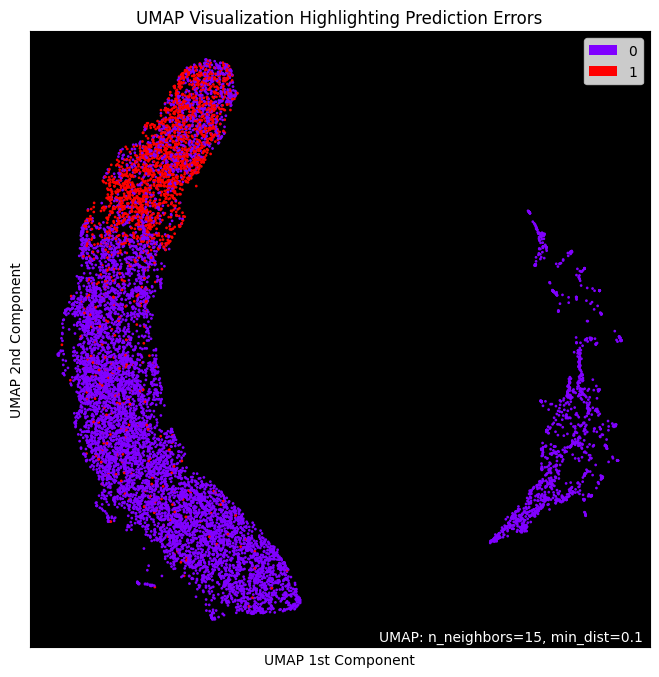

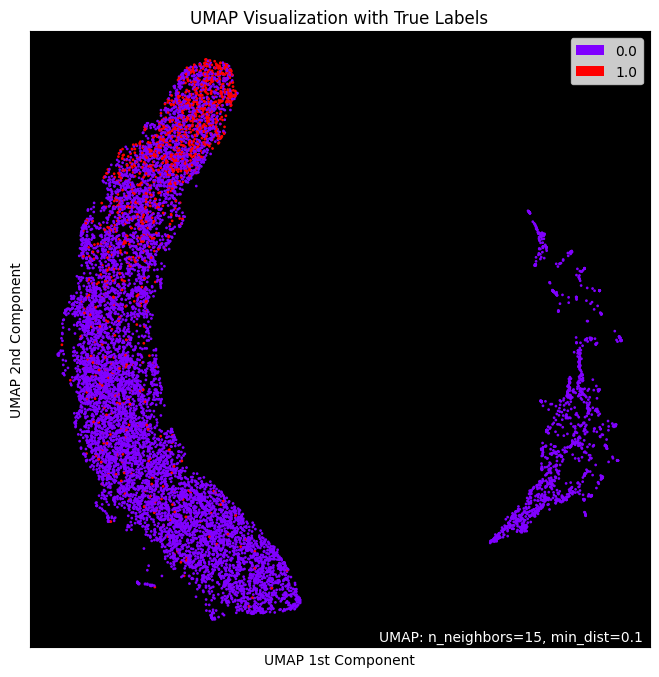

In [18]:
# Error and Label Lists
errors = [0 if y_pred[ix,0] == y_test.values[ix] else 1 for ix in range(len(y_pred[:,0]))]
labels = [y_test.values[ix] for ix in range(len(y_pred[:,0]))]

# Visualization using UMAP
umap.plot.points(mapper, labels=np.array(errors), theme='fire')
plt.gca().set_title('UMAP Visualization Highlighting Prediction Errors')
plt.xlabel('UMAP 1st Component')
plt.ylabel('UMAP 2nd Component')
plt.show()

umap.plot.points(mapper, labels=np.array(labels), theme='fire')
plt.gca().set_title('UMAP Visualization with True Labels')
plt.xlabel('UMAP 1st Component')
plt.ylabel('UMAP 2nd Component')
plt.show()

Permutation Importance

In [19]:
def permutation_importance(model, X_val_scaled, y_val, metric=accuracy_score):
    """
    Calculate permutation importance for a given model and validation set.

    Parameters:
    - model: Trained model
    - X_val: Validation data (features)
    - y_val: True labels for validation data
    - metric: Performance metric function

    Returns:
    - importances: Feature importance scores
    """
    feature_names = X.columns.tolist()

    # Get the original performance of the model
    original_preds = model.predict(X_val_scaled)
    # Convert predictions to binary values
    original_preds_binary = (original_preds > 0.5).astype(int)
    original_score = metric(y_val, original_preds_binary)

    # Calculate permutation importance for each feature
    importances = []
    for col in range(X_val_scaled.shape[1]):
        X_val_copy = X_val_scaled.copy()
        np.random.shuffle(X_val_copy[:, col])
        shuffled_preds = model.predict(X_val_copy, verbose=0)
        shuffled_preds_binary = (shuffled_preds > 0.5).astype(int)
        shuffled_score = metric(y_val, shuffled_preds_binary)
        importances.append(original_score - shuffled_score)

    return np.array(importances)

feature_names = X.columns.tolist()

# Calculate permutation importance
feature_importances = permutation_importance(model, X_val_scaled, y_val)

# Pair feature names with their importances
feature_importance_pairs = list(zip(feature_names, feature_importances))

# Sort feature importances in descending order
sorted_feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Display feature importances in descending order
for name, imp in sorted_feature_importance_pairs:
    print(f"Feature {name}: {imp}")


295/295 [==============================] - 0s 1ms/step
Feature WBC: 0.04758372191606608
Feature S: 0.019499788045782118
Feature Free Calcium: 0.006146672318779078
Feature RBC: 0.00540483255616786
Feature ADMISSION_LOCATION_EMERGENCY ROOM ADMIT: 0.004768969902501086
Feature PT: 0.0041331072488342
Feature GENDER_F: 0.0036032217041118697
Feature Lactate: 0.003391267486222982
Feature ETHNICITY_BLACK/AFRICAN AMERICAN: 0.003179313268333983
Feature ADMISSION_LOCATION_TRANSFER FROM HOSP/EXTRAM: 0.0028613819415006514
Feature Hyaline Casts: 0.0028613819415006514
Feature MCHC: 0.0028613819415006514
Feature Procedure: Lung Biopsy and Intervention: 0.0025434506146672087
Feature AGE_AT_ADMISSION: 0.0025434506146672087
Feature Procedure: Catheterization and Ventilation Techniques: 0.0024374735057227648
Feature Fibrinogen, Functional: 0.002331496396778321
Feature White Blood Cells: 0.002225519287833766
Feature GENDER_M: 0.002225519287833766
Feature Ferritin: 0.002119542178889322
Feature Asparate Amino

## Optuna - Hyperparameter Search

Using Optuna to optimize the hyperparameters of neural network

```python
def objective(trial):
    # Hyperparameters to be optimized
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.8)  # increasing max dropout
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 5)  # increasing max layers
    optimizer_selected = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD', 'Adagrad'])
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256])
    activation = trial.suggest_categorical('activation', ['relu', 'sigmoid', 'swish', 'tanh', 'elu', 'selu'])
    weight_initializer = trial.suggest_categorical('weight_initializer', ['glorot_uniform', 'he_uniform', 'lecun_uniform'])
    
    model = Sequential()
    model.add(Dense(trial.suggest_int('units_layer_0', 8, 256, log=True),
                    input_shape=(X_train_scaled.shape[1],), activation=activation, kernel_initializer=weight_initializer))
    
    for i in range(1, num_hidden_layers + 1):
        model.add(Dense(trial.suggest_int(f'units_layer_{i}', 8, 256, log=True), activation=activation, kernel_initializer=weight_initializer))
        model.add(Dropout(dropout_rate))
        
    model.add(Dense(1, activation='sigmoid'))
    
    if optimizer_selected == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_selected == 'RMSprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_selected == 'Adagrad':
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=batch_size,
                        sample_weight=sample_weights, validation_data=(X_val_scaled, y_val), verbose=0,
                        callbacks=[early_stopping, lr_scheduler, TFKerasPruningCallback(trial, 'val_accuracy')])
    
    val_accuracy = history.history['val_accuracy'][-1]
    return val_accuracy

# Using pruning
pruner = optuna.pruners.MedianPruner()
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(objective, n_trials=200, timeout=7200)  # increased the number of trials

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
```

```
Number of finished trials:  131
Best trial:
  Value: 0.889147937297821
  Params:
    dropout_rate: 0.3805232216149589
    num_hidden_layers: 5
    optimizer: RMSprop
    learning_rate: 0.006383910844339045
    batch_size: 16
    activation: tanh
    weight_initializer: lecun_uniform
    units_layer_0: 176
    units_layer_1: 34
    units_layer_2: 65
    units_layer_3: 17
    units_layer_4: 15
    units_layer_5: 14
```

```python
def build_model(hyperparams):
    model = Sequential()

    # Input layer
    model.add(Dense(hyperparams['units_layer_0'], input_shape=(X_train_scaled.shape[1],), activation=hyperparams['activation'], kernel_initializer=hyperparams['weight_initializer']))
    
    # Hidden layers
    for i in range(hyperparams['num_hidden_layers']):
        model.add(Dense(hyperparams[f'units_layer_{i}'], activation=hyperparams['activation'], kernel_initializer=hyperparams['weight_initializer']))
        model.add(Dropout(hyperparams['dropout_rate']))
        
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Optimizer
    if hyperparams['optimizer'] == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=hyperparams['learning_rate'])
    elif hyperparams['optimizer'] == 'RMSprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=hyperparams['learning_rate'])
    elif hyperparams['optimizer'] == 'Adagrad':
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=hyperparams['learning_rate'])
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=hyperparams['learning_rate'])

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Get best hyperparameters from the Optuna study
best_hyperparams = trial.params

# Build the model
best_model = build_model(best_hyperparams)

# Compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Performance Scheduling
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

# Early stopping
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Train the model using the best batch size from Optuna study
history = best_model.fit(X_train_scaled, y_train, epochs=100, batch_size=best_hyperparams['batch_size'],
                         sample_weight=sample_weights, validation_data=(X_val_scaled, y_val),
                         callbacks=[early_stopping, lr_scheduler])

```

```
              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91     10463
         1.0       0.38      0.59      0.47      1333

    accuracy                           0.85     11796
   macro avg       0.66      0.74      0.69     11796
weighted avg       0.88      0.85      0.86     11796

[51]
0s
# calculate balanced accuracy
print(f"{balanced_accuracy_score(y_test, dnn_y_test_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, dnn_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")
output
73.67% - Balanced accuracy Test
74.56% - Balanced accuracy Train
```

## Deep Neural Network (DNN)

In [20]:
# Compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Performance Scheduling
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

# early stopping
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)


model = Sequential()
model.add(Dense(64, input_shape=(X_train_scaled.shape[1],), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=64, sample_weight=sample_weights, validation_data=(X_val_scaled, y_val),
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
590/590 [==============================] - 4s 4ms/step - loss: 0.5260 - accuracy: 0.7184 - val_loss: 0.4449 - val_accuracy: 0.7857 - lr: 0.0010
Epoch 2/100
590/590 [==============================] - 2s 3ms/step - loss: 0.4744 - accuracy: 0.7585 - val_loss: 0.4736 - val_accuracy: 0.7621 - lr: 0.0010
Epoch 3/100
590/590 [==============================] - 2s 3ms/step - loss: 0.4604 - accuracy: 0.7555 - val_loss: 0.4485 - val_accuracy: 0.7638 - lr: 0.0010
Epoch 4/100
590/590 [==============================] - 2s 3ms/step - loss: 0.4536 - accuracy: 0.7575 - val_loss: 0.4140 - val_accuracy: 0.7833 - lr: 0.0010
Epoch 5/100
590/590 [==============================] - 2s 3ms/step - loss: 0.4484 - accuracy: 0.7602 - val_loss: 0.4257 - val_accuracy: 0.7826 - lr: 0.0010
Epoch 6/100
590/590 [==============================] - 2s 3ms/step - loss: 0.4428 - accuracy: 0.7609 - val_loss: 0.4278 - val_accuracy: 0.7850 - lr: 0.0010
Epoch 7/100
590/590 [==============================] - 2s 3ms/st

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                5184      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 1

Plot Learning Curves

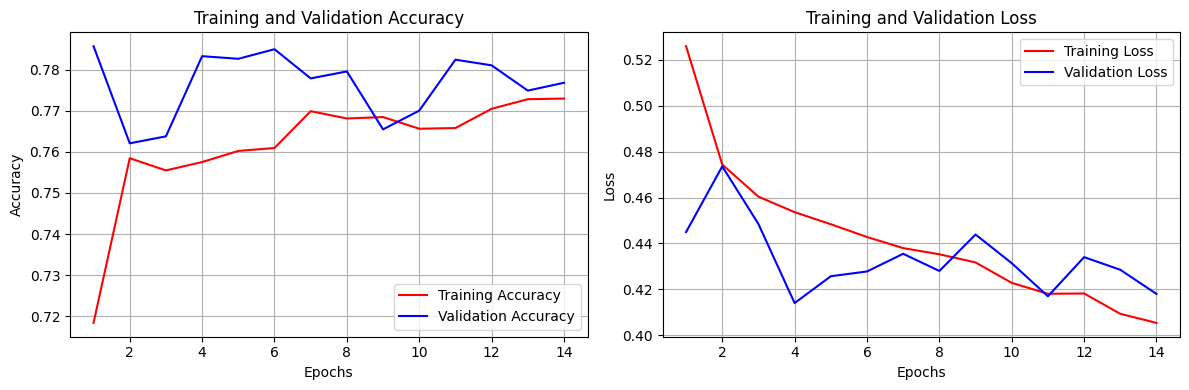

In [22]:
def plot_learning_curves(history):
    # Extract the training and validation losses & accuracies
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 4))

    # Plot training and validation accuracies
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot training and validation losses
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

**DNN Model Evaluation**

In [23]:
# train and test predictions
dnn_y_test_pred = model.predict(X_test_scaled)
dnn_y_train_pred = model.predict(X_train_scaled)

1180/1180 [==============================] - 1s 1ms/step


In [24]:
print(classification_report(y_test, dnn_y_test_pred.round()))

              precision    recall  f1-score   support

         0.0       0.97      0.78      0.86     10463
         1.0       0.32      0.81      0.46      1333

    accuracy                           0.78     11796
   macro avg       0.64      0.79      0.66     11796
weighted avg       0.90      0.78      0.82     11796



In [25]:
# calculate balanced accuracy
print(f"{balanced_accuracy_score(y_test, dnn_y_test_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, dnn_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")

79.45% - Balanced accuracy Test
80.61% - Balanced accuracy Train


In [26]:
# define labels
labels = ['non-UTI', 'UTI']

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.show()

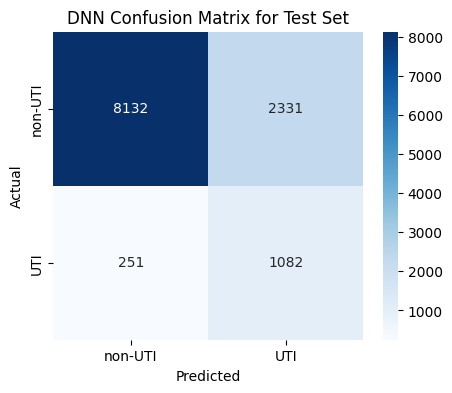

In [27]:
plot_confusion_matrix(y_test, dnn_y_test_pred.round(), title='DNN Confusion Matrix for Test Set')

369/369 [==============================] - 0s 1ms/step


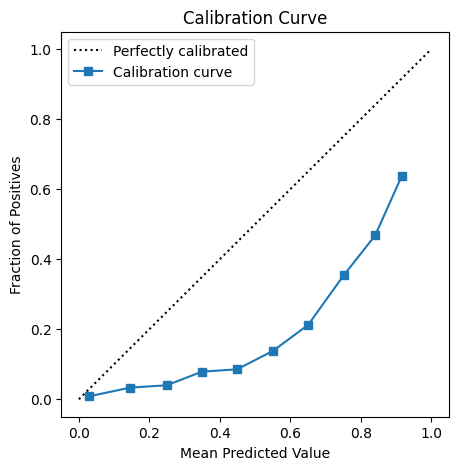

In [28]:
# calibration curve
dnn_y_test_pred = model.predict(X_test_scaled)
prob_true, prob_pred = calibration_curve(y_test, dnn_y_test_pred, n_bins=10, strategy='uniform')

plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
plt.plot(prob_pred, prob_true, 's-', label='Calibration curve')
plt.ylabel('Fraction of Positives')
plt.xlabel('Mean Predicted Value')
plt.legend()
plt.title('Calibration Curve')
plt.show()

Perfectly Calibrated: In a perfectly calibrated model, the calibration curve would be a diagonal line, going from the bottom left corner to the top right corner of the plot (i.e., a 45-degree line, often labeled as "Perfectly calibrated").

Over-confident: If the curve is below the diagonal line, the model's predicted probabilities are generally higher than the actual fraction of positives, indicating over-confidence.

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


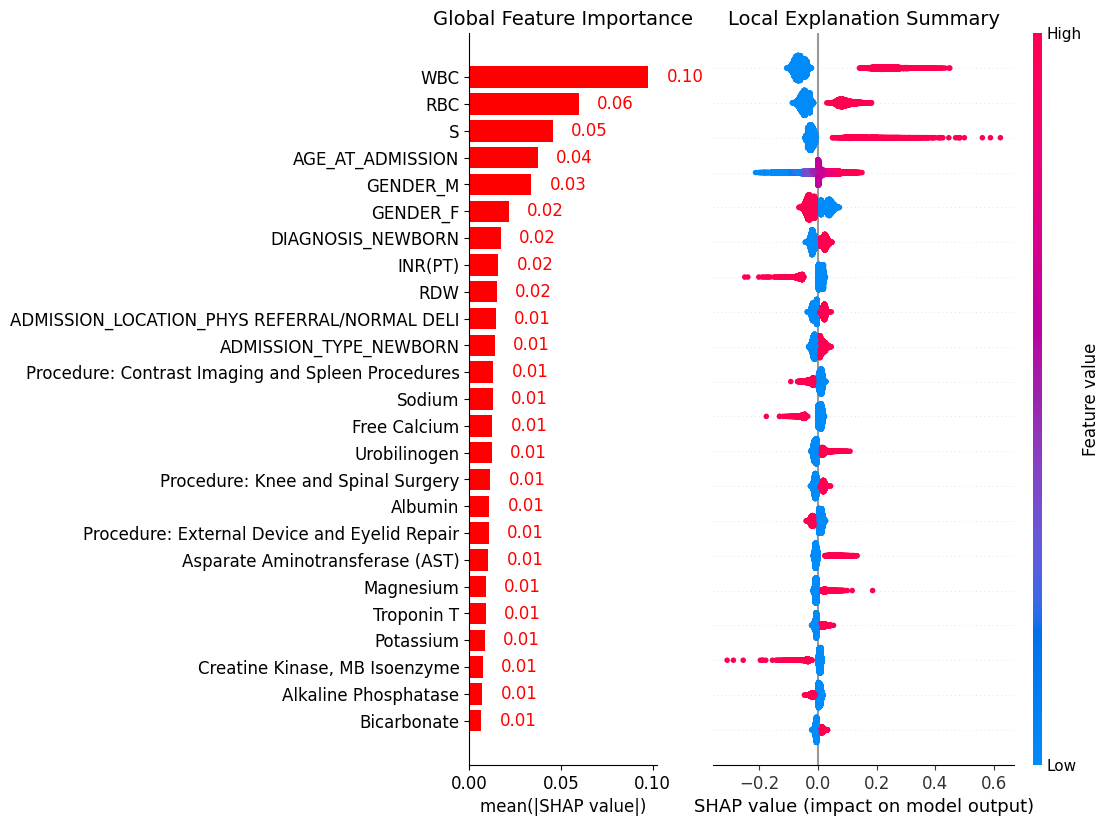

In [29]:
## SHAP

# Get feature names
feature_names = X.columns.tolist()

X_train_scaled = X_train_scaled.astype(np.float32)
random_indices = np.random.choice(X_train_scaled.shape[0], size=1000, replace=False)
subset_data = X_train_scaled[random_indices]

# Compute SHAP values for a particular set (e.g., test set)
# Using DeepExplainer for Deep Neural Network model:
explainer = shap.DeepExplainer(model, subset_data)
shap_values = explainer.shap_values(X_test_scaled)

# The first set of values from the list of shap_values for binary classification
shap_values_array = shap_values[0]

# Calculate mean absolute SHAP values for global importance
global_shap_vals = np.abs(shap_values_array).mean(axis=0)

# Sort features based on their global importance
sorted_indices = np.argsort(global_shap_vals)[-25:]
top_features = np.array(feature_names)[sorted_indices]
top_global_shap_vals = global_shap_vals[sorted_indices]

# Subset the data and SHAP values for top features
top_shap_values = shap_values_array[:, sorted_indices]
X_test_top_features = X_test_scaled[:, sorted_indices]

# Create a combined plot with subplots using GridSpec for layout
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])

# Plot global importance of top features on left
ax1 = plt.subplot(gs[0])
bars = ax1.barh(top_features, top_global_shap_vals, color='red')
ax1.set_xlabel('mean(|SHAP value|)', fontsize=12)
ax1.set_title('Global Feature Importance', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Add values beside the bar with red color
for bar in bars:
    ax1.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.2f}',
             va='center', ha='left', color='red', fontsize=12)

# Plot typical SHAP values on right
ax2 = plt.subplot(gs[1])
shap.summary_plot(top_shap_values, X_test_top_features, feature_names=top_features, plot_type="dot", show=False)
ax2.set_title('Local Explanation Summary', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_yticks([])
ax2.set_yticklabels([])

plt.show()

## Random Forest

Optuna Hyperparameter Search

```python
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    # Define range of hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt'])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])
    max_samples = trial.suggest_float('max_samples', 0.1, 1.0) if bootstrap else None

    # Create and train classifier
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        criterion=criterion,
        class_weight=class_weight,
        max_samples=max_samples,
        random_state=42
    )
    
    return cross_val_score(clf, X_train_scaled, y_train, n_jobs=-1, cv=3).mean()

# Create study object and specify direction is 'maximize' for classification tasks
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # Adjust n_trials based on your resources

# Results
print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('Value: ', trial.value)
print('Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

```

```
Number of finished trials:  100
Best trial:
Value:  0.89253921137945
Params:
    n_estimators: 73
    max_depth: 16
    min_samples_split: 6
    min_samples_leaf: 5
    max_features: auto
    bootstrap: False
    criterion: entropy
    class_weight: None
```

```python
# Retrieve the best hyperparameters
best_params = study.best_params

# Incorporate the best hyperparameters into your RandomForestClassifier
rf = RandomForestClassifier(**best_params, random_state=42)

# Fit the classifier with the training data
rf.fit(X_train_scaled, y_train)
```

```
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94     10463
         1.0       0.63      0.07      0.12      1333

    accuracy                           0.89     11796
   macro avg       0.76      0.53      0.53     11796
weighted avg       0.86      0.89      0.85     11796

[66]
0s
# calculate balanced accuracy
print(f"{balanced_accuracy_score(y_test, rf_y_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, rf_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")
output
53.06% - Balanced accuracy Test
68.46% - Balanced accuracy Train
```

In [30]:
# rf = RandomForestClassifier(n_estimators=100, random_state=42)
# rf.fit(X_train_scaled, y_train)

# rf_y_pred = rf.predict(X_test_scaled)
# rf_y_train_pred = rf.predict(X_train_scaled)
# print(classification_report(y_test, rf_y_pred))

RandomForestClassifier(random_state=42)

In [65]:
# using the best parameters
best_param_rf = {'max_depth': 10,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 83}

rf = RandomForestClassifier(**best_param_rf,random_state=42, class_weight='balanced')
rf.fit(X_train_scaled, y_train)

rf_y_pred = rf.predict(X_test_scaled)
rf_y_train_pred = rf.predict(X_train_scaled)
print(classification_report(y_test, rf_y_pred))

# calculate balanced accuracy
print(f"{balanced_accuracy_score(y_test, rf_y_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, rf_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")

              precision    recall  f1-score   support

         0.0       0.97      0.80      0.88     10463
         1.0       0.34      0.79      0.47      1333

    accuracy                           0.80     11796
   macro avg       0.65      0.79      0.67     11796
weighted avg       0.90      0.80      0.83     11796

79.46% - Balanced accuracy Test
83.46% - Balanced accuracy Train


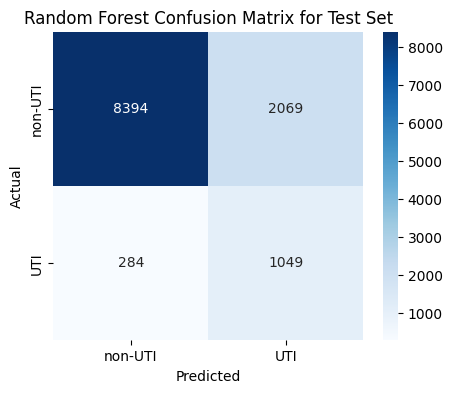

In [56]:
plot_confusion_matrix(y_test, rf_y_pred.round(), title='Random Forest Confusion Matrix for Test Set')

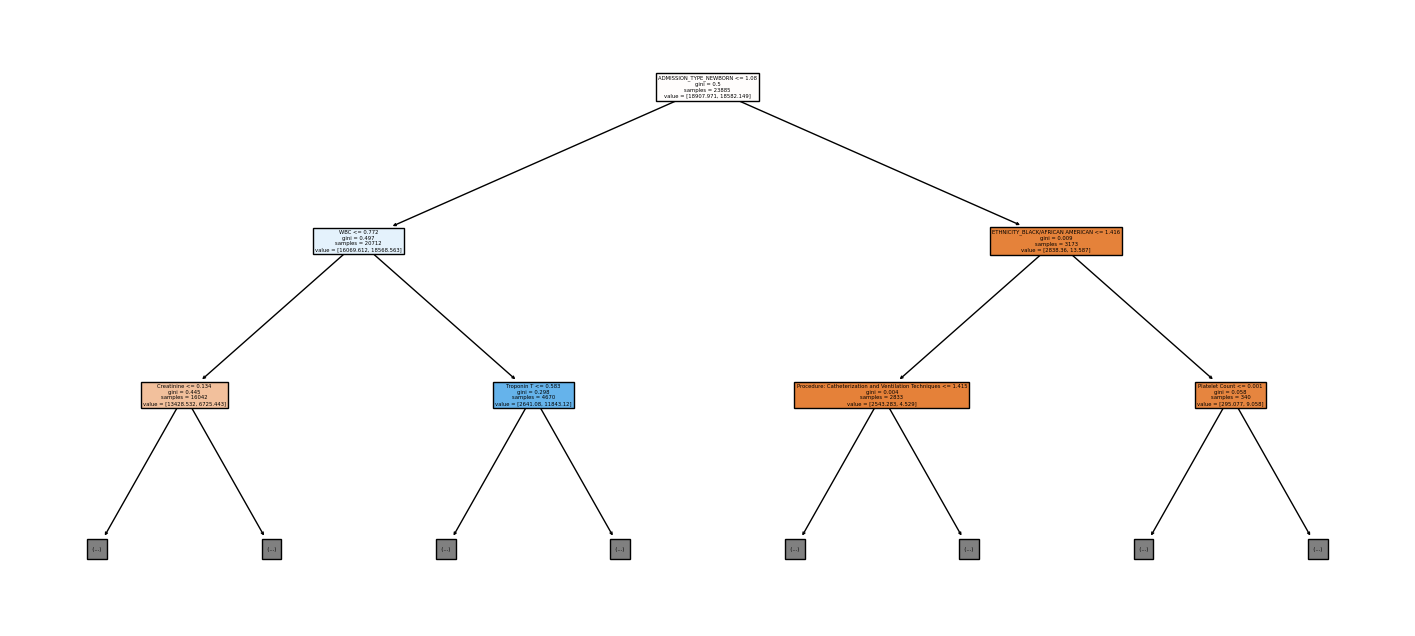

In [57]:
# Visualizing the first decision tree
plt.figure(figsize=(18,8))
plot_tree(rf.estimators_[0], filled=True, max_depth=2, feature_names=X.columns)
plt.show()

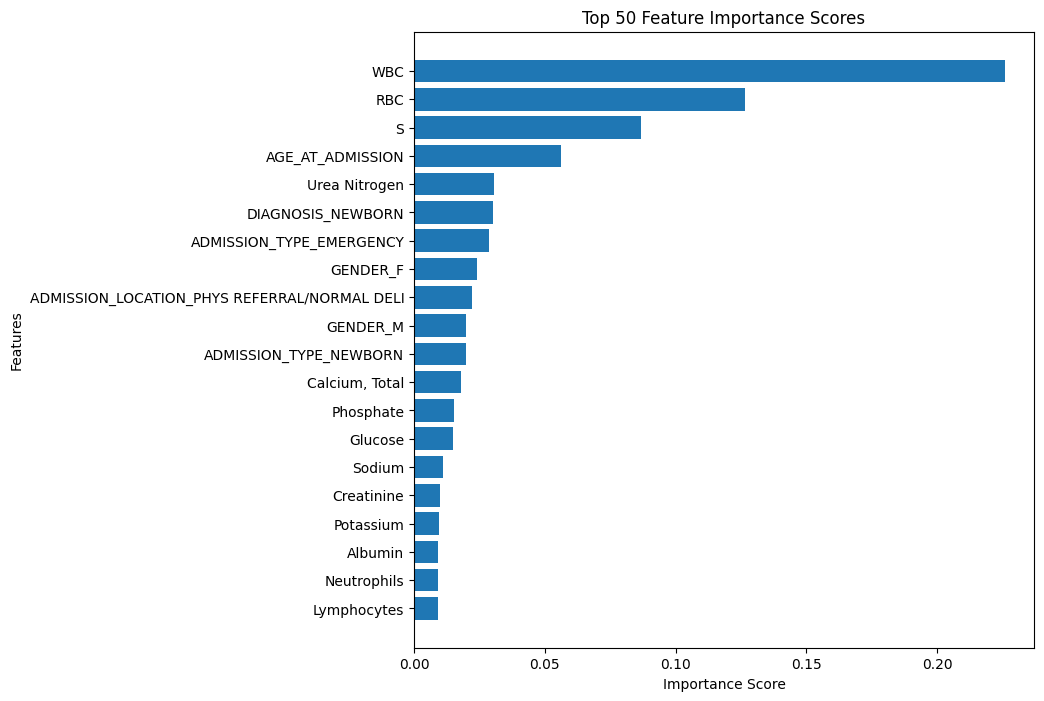

In [58]:
importances = rf.feature_importances_
features = X.columns

# Get the indices of the top features
sorted_indices = np.argsort(importances)[-20:]

plt.figure(figsize=(8,8))
plt.barh(features[sorted_indices], importances[sorted_indices])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 50 Feature Importance Scores')
plt.show()


### Risk Scores

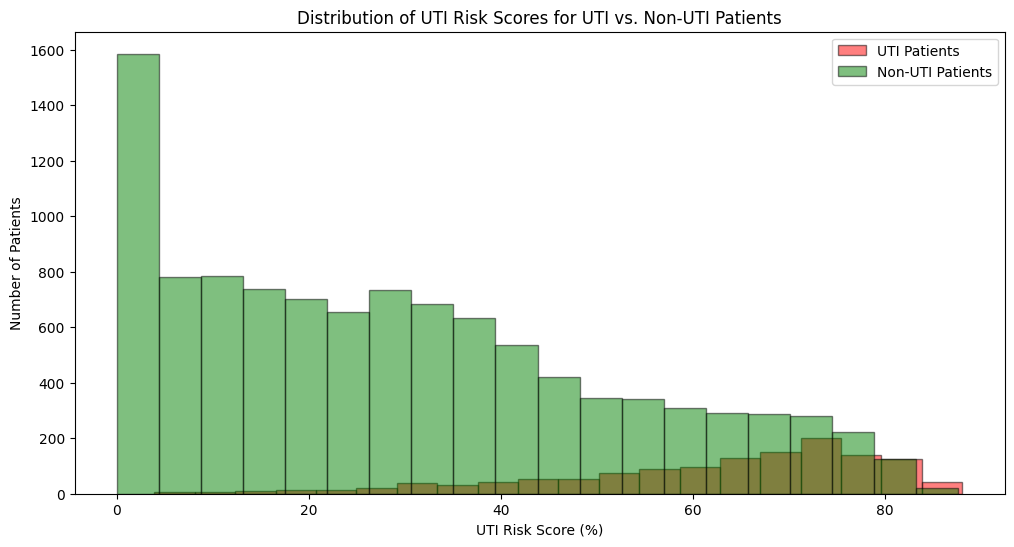

In [59]:
# Predict probabilities
probabilities = rf.predict_proba(X_test_scaled)

# Extract uti risk scores
uti_risk_scores = probabilities[:, 1]
uti_risk_scores_percentage = uti_risk_scores * 100

uti_scores = uti_risk_scores_percentage[y_test == 1]
non_uti_scores = uti_risk_scores_percentage[y_test == 0]

plt.figure(figsize=(12,6))

# Histogram for UTI patients
plt.hist(uti_scores, bins=20, color='red', alpha=0.5, label='UTI Patients', edgecolor='black')

# Histogram for non-UTI patients
plt.hist(non_uti_scores, bins=20, color='green', alpha=0.5, label='Non-UTI Patients', edgecolor='black')

plt.xlabel('UTI Risk Score (%)')
plt.ylabel('Number of Patients')
plt.title('Distribution of UTI Risk Scores for UTI vs. Non-UTI Patients')
plt.legend()
plt.show()


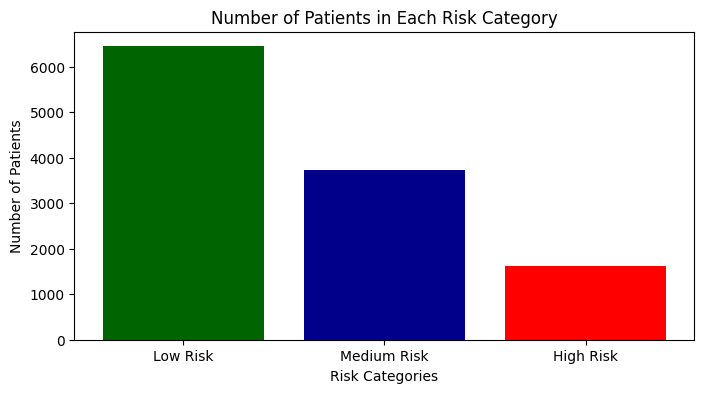

In [60]:
# Risk Categories
categories = ['Low Risk', 'Medium Risk', 'High Risk']
counts = [
    sum(uti_risk_scores_percentage <= 33),
    sum((uti_risk_scores_percentage > 33) & (uti_risk_scores_percentage <= 66)),
    sum(uti_risk_scores_percentage > 66)
]

plt.figure(figsize=(8,4))
plt.bar(categories, counts, color=['darkgreen', 'darkblue', 'red'])
plt.xlabel('Risk Categories')
plt.ylabel('Number of Patients')
plt.title('Number of Patients in Each Risk Category')
plt.show()


## XGBoost

In [38]:
# import optuna
# import xgboost as xgb
# from sklearn.metrics import classification_report
# from sklearn.model_selection import cross_val_score

# def objective(trial):
#     # Define range of hyperparameters
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'max_depth': trial.suggest_int('max_depth', 2, 25),
#         'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5, log=True),
#         'subsample': trial.suggest_float('subsample', 0.1, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
#         'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1.0),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'gamma': trial.suggest_float('gamma', 0.1, 1.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10.0, log=True),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10.0, log=True),
#         'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.1, 10.0),
#         'objective': 'binary:logistic',
#         'random_state': 42
#     }

#     booster = trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart'])
#     if booster == 'dart':
#         params['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
#         params['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
#         params['rate_drop'] = trial.suggest_float('rate_drop', 0, 1.0)
#         params['skip_drop'] = trial.suggest_float('skip_drop', 0, 1.0)
#     params['booster'] = booster

#     # Create and train classifier
#     clf = xgb.XGBClassifier(**params)

#     return cross_val_score(clf, X_train_scaled, y_train, n_jobs=-1, cv=3).mean()

# # Create study object and specify direction is 'maximize' for classification tasks
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=200)  # Adjust n_trials based on your resources

# # Results
# best_params = study.best_params
# best_params

# # Use the best hyperparameters to create and train the model
# xgb_model = xgb.XGBClassifier(**best_params, objective="binary:logistic", random_state=42)
# xgb_model.fit(X_train_scaled, y_train)

# # Predict using test and train sets
# xgb_predictions = xgb_model.predict(X_test_scaled)
# xgb_train_predictions = xgb_model.predict(X_train_scaled)

# # Show classification report
# print("XGBoost Classification Report:\n")
# print(classification_report(y_test, xgb_predictions))

In [64]:
# # Create and train the model
# xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
# xgb_model.fit(X_train_scaled, y_train)

# # predict using test set
# xgb_predictions = xgb_model.predict(X_test_scaled)
# xgb_train_predictions = xgb_model.predict(X_train_scaled)

# # show classification report
# print("XGBoost Classification Report:\n")
# print(classification_report(y_test, xgb_predictions))

In [62]:
# XGBoost best hyperparameters
best_params_xgb_binlog = {'learning_rate': 0.07333333333333333, 'max_depth': 3, 'n_estimators': 450}

# amend for class imbalances
class_weights = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# run on best parameters
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, **best_params_xgb_binlog, scale_pos_weight=class_weights)
xgb_model.fit(X_train_scaled, y_train)

# predict using test set
xgb_predictions = xgb_model.predict(X_test_scaled)
xgb_train_predictions = xgb_model.predict(X_train_scaled)

# show classification report
print("XGBoost Classification Report:\n")
print(classification_report(y_test, xgb_predictions))

# show balanced accuracy
print(f"{balanced_accuracy_score(y_test, xgb_predictions.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, xgb_train_predictions.round()) * 100:.2f}% - Balanced accuracy Train")

XGBoost Classification Report:

              precision    recall  f1-score   support

         0.0       0.97      0.79      0.87     10463
         1.0       0.33      0.80      0.46      1333

    accuracy                           0.79     11796
   macro avg       0.65      0.80      0.67     11796
weighted avg       0.90      0.79      0.82     11796

79.69% - Balanced accuracy Test
81.30% - Balanced accuracy Train


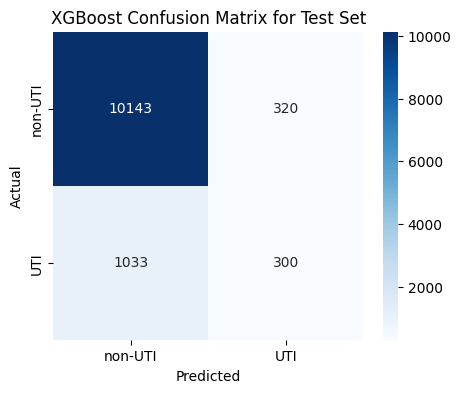

In [42]:
plot_confusion_matrix(y_test, xgb_predictions.round(), title='XGBoost Confusion Matrix for Test Set')

## LightGBM

Optuna Hyperparameter Search

In [43]:
# import optuna
# import lightgbm as lgb
# from sklearn.metrics import classification_report
# from sklearn.model_selection import cross_val_score

# def objective(trial):
#     # Define range of hyperparameters
#     params = {
#         'num_leaves': trial.suggest_int('num_leaves', 2, 256),
#         'max_bin': trial.suggest_int('max_bin', 32, 255),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 256),
#         'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5, log=True),
#         'min_sum_hessian_in_leaf': trial.suggest_float('min_sum_hessian_in_leaf', 1e-4, 10.0, log=True),
#         'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 0, 7),
#         'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
#         'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
#         'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
#         'min_gain_to_split': trial.suggest_float('min_gain_to_split', 1e-8, 1.0, log=True),
#         'objective': trial.suggest_categorical('objective', ['binary', 'multiclass', 'cross_entropy', 'cross_entropy_lambda']),
#         'random_state': 42
#     }

#     if params['objective'] == 'multiclass':
#         params['num_class'] = 2

#     # Create and train classifier
#     clf = lgb.LGBMClassifier(**params)

#     return cross_val_score(clf, X_train_scaled, y_train, n_jobs=-1, cv=3).mean()

# # Create study object and specify direction is 'maximize' for classification tasks
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)  # Adjust n_trials based on your resources

# # Results
# best_params = study.best_params

# # Use the best hyperparameters to create and train the model
# lgb_model = lgb.LGBMClassifier(**best_params, random_state=42)
# lgb_model.fit(X_train_scaled, y_train)

# # Predict using test and train sets
# lgb_predictions = lgb_model.predict(X_test_scaled)
# lgb_train_predictions = lgb_model.predict(X_train_scaled)

# # Show classification report
# print("LightGBM Classification Report:\n")
# print(classification_report(y_test, lgb_predictions))


In [44]:
# # Create and train the model
# lgb_model = lgb.LGBMClassifier(objective="binary", random_state=42)
# lgb_model.fit(X_train_scaled, y_train)

# # predict using test set
# lgb_predictions = lgb_model.predict(X_test_scaled)
# lgb_train_predictions = lgb_model.predict(X_train_scaled)

# # show classification report
# print("LightGBM Classification Report:\n")
# print(classification_report(y_test, lgb_predictions))

# # calculate balanced accuracy
# print(f"{balanced_accuracy_score(y_test, lgb_predictions.round()) * 100:.2f}% - Balanced accuracy Test")
# print(f"{balanced_accuracy_score(y_train, lgb_train_predictions.round()) * 100:.2f}% - Balanced accuracy Train")

[LightGBM] [Info] Number of positive: 4167, number of negative: 33577
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 385
[LightGBM] [Info] Number of data points in the train set: 37744, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.110402 -> initscore=-2.086645
[LightGBM] [Info] Start training from score -2.086645
LightGBM Classification Report:

              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94     10463
         1.0       0.55      0.16      0.25      1333

    accuracy                           0.89     11796
   macro avg       0.72      0.57      0.60     11796
weighted avg       0.86      0.89      0.86     11796



In [69]:
# LightGBM best hyperparameters
best_params = {'boosting_type': 'gbdt',
 'learning_rate': 0.1,
 'metric': 'binary_logloss',
 'min_child_samples': 30,
 'num_leaves': 50,
 'objective': 'binary'}

X_train_scaled.columns = ["".join([c if c.isalnum() else "_" for c in str(x)]) for x in X_train_scaled.columns]

# fit model with best parameters
lgb_best = lgb.LGBMClassifier(**best_params, scale_pos_weight=class_weights, random_state=42)
lgb_best.fit(X_train_scaled, y_train)

# predict using test set
lgb_predictions = lgb_best.predict(X_test_scaled)
lgb_train_predictions = lgb_best.predict(X_train_scaled)

# show classification report
print("LightGBM Classification Report:\n")
print(classification_report(y_test, lgb_predictions))

# show balanced accuracy
print(f"{balanced_accuracy_score(y_test, lgb_predictions.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, lgb_train_predictions.round()) * 100:.2f}% - Balanced accuracy Train")

[LightGBM] [Info] Number of positive: 4167, number of negative: 33577
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 385
[LightGBM] [Info] Number of data points in the train set: 37744, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.110402 -> initscore=-2.086645
[LightGBM] [Info] Start training from score -2.086645
LightGBM Classification Report:

              precision    recall  f1-score   support

         0.0       0.97      0.81      0.88     10463
         1.0       0.34      0.78      0.47      1333

    accuracy                           0.80     11796
   macro avg       0.65      0.79      0.68     11796
weighted avg       0.90      0.80      0.83     11796

79.19% - Balanced accuracy Test
87.67% - Balanced accuracy Train


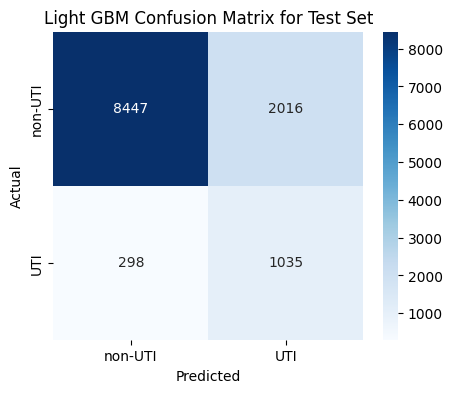

In [70]:
plot_confusion_matrix(y_test, lgb_predictions.round(), title='Light GBM Confusion Matrix for Test Set')

## Logistic Regression

In [47]:
# import optuna
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import classification_report
# from sklearn.model_selection import cross_val_score

# def objective(trial):
#     # Define range of hyperparameters
#     params = {
#         'C': trial.suggest_float('C', 1e-4, 10.0, log=True),
#         'penalty': trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', 'none']),
#         'solver': trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
#         'class_weight': 'balanced',
#         'max_iter': 1000,
#         'random_state': 42
#     }

#     if params['penalty'] == 'none':
#         params.pop('solver')  # If penalty is none, solver is set automatically to 'lbfgs'

#     if params['penalty'] == 'elasticnet':
#         params['l1_ratio'] = trial.suggest_float('l1_ratio', 0.0, 1.0)

#     # Create and train classifier
#     clf = LogisticRegression(**params)

#     return cross_val_score(clf, X_train_scaled, y_train, n_jobs=-1, cv=3).mean()

# # Create study object and specify direction is 'maximize' for classification tasks
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)  # Adjust n_trials based on your resources

# # Results
# best_params = study.best_params

# # Use the best hyperparameters to create and train the model
# logistic_model = LogisticRegression(**best_params, random_state=42, class_weight='balanced', max_iter=1000)
# logistic_model.fit(X_train_scaled, y_train)

# # Predict using test and train sets
# logistic_predictions = logistic_model.predict(X_test_scaled)
# logistic_train_predictions = logistic_model.predict(X_train_scaled)

# # Show classification report
# print("Logistic Regression Classification Report:\n")
# print(classification_report(y_test, logistic_predictions))

In [48]:
# Create and train the model with balanced class weights and increased iterations
logistic_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
logistic_model.fit(X_train_scaled, y_train)

# Predict using test set
logistic_predictions = logistic_model.predict(X_test_scaled)
logistic_train_predictions = logistic_model.predict(X_train_scaled)

# Show classification report
print("Logistic Regression Classification Report:\n")
print(classification_report(y_test, logistic_predictions))


Logistic Regression Classification Report:

              precision    recall  f1-score   support

         0.0       0.97      0.79      0.87     10463
         1.0       0.33      0.80      0.47      1333

    accuracy                           0.79     11796
   macro avg       0.65      0.79      0.67     11796
weighted avg       0.90      0.79      0.83     11796



In [49]:
# calculate balanced accuracy
print(f"{balanced_accuracy_score(y_test, logistic_predictions.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, logistic_train_predictions.round()) * 100:.2f}% - Balanced accuracy Train")

79.49% - Balanced accuracy Test
79.37% - Balanced accuracy Train


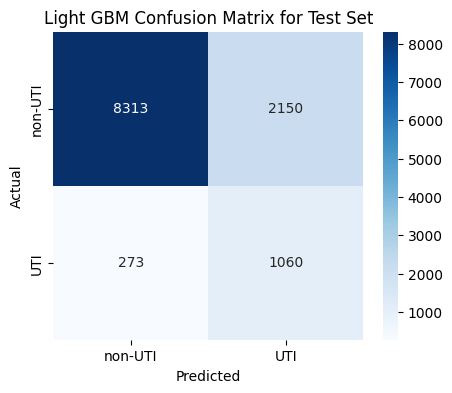

In [50]:
plot_confusion_matrix(y_test, logistic_predictions.round(), title='Light GBM Confusion Matrix for Test Set')

**SHAP (SHapley Additive exPlanations)**

Explain the output of machine learning models and identifying feature importance by using Shapley values to fairly allocate contributions of each feature for individual predictions.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


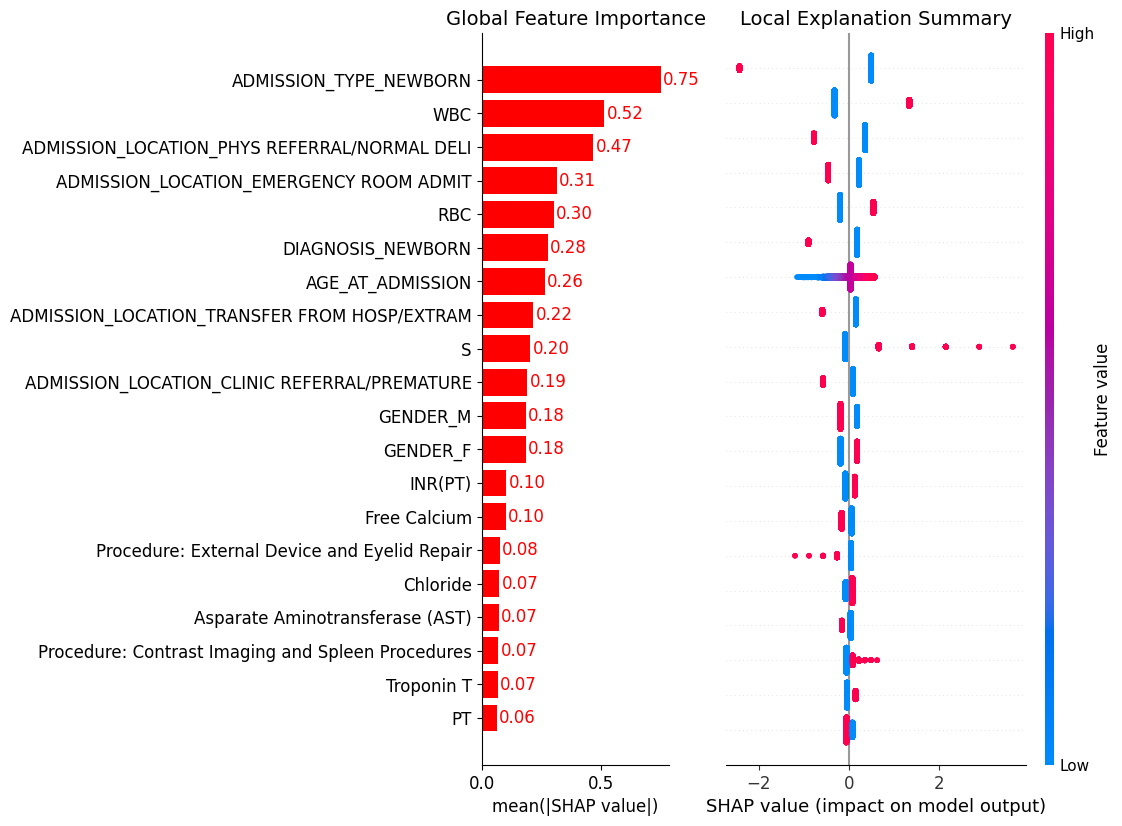

In [51]:
# Get feature names
feature_names = X.columns.tolist()

# # Convert training and test sets to DataFrames with those feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

# Initialize the explainer object with the appropriate masker
masker = shap.maskers.Independent(data=X_train_scaled)
explainer = shap.LinearExplainer(logistic_model, masker=masker)

# Compute SHAP values for a particular set (e.g., test set)
shap_values_obj = explainer(X_test_scaled)

# Extract values from the Explanation object
shap_values_array = shap_values_obj.values

# Calculate mean absolute SHAP values for global importance
global_shap_vals = np.abs(shap_values_array).mean(axis=0)

# Sort features based on their global importance
sorted_indices = np.argsort(global_shap_vals)[-20:]
top_features = np.array(feature_names)[sorted_indices]
top_global_shap_vals = global_shap_vals[sorted_indices]

# Subset the data and SHAP values for top features
top_shap_values = shap_values_array[:, sorted_indices]
X_test_top_features = X_test_scaled[top_features]

# Plot global importance of top features on left
ax1 = plt.subplot(gs[0])
bars = ax1.barh(top_features, top_global_shap_vals, color='red')
ax1.set_xlabel('mean(|SHAP value|)', fontsize=12)  # Adjust font size
ax1.set_title('Global Feature Importance', fontsize=14)  # Adjust font size
ax1.tick_params(axis='both', which='major', labelsize=12)  # Adjust tick font size

# Remove the top and right spines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Add values beside the bar
for bar in bars:
    ax1.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.2f}',
             va='center', ha='left', color='red', fontsize=12)  # Adjust font size

# Plot typical SHAP values on right using only the top features
ax2 = plt.subplot(gs[1])
shap.summary_plot(top_shap_values, X_test_top_features, feature_names=top_features, plot_type="dot", show=False)
ax2.set_title('Local Explanation Summary', fontsize=14)  # Add title and adjust font size
ax2.tick_params(axis='both', which='major', labelsize=12)  # Adjust tick font size

# Turn off y-axis ticks and labels for ax2 (SHAP dot plot)
ax2.set_yticks([])
ax2.set_yticklabels([])

plt.show()

Red: Feature has a high value for that observation

Blue: Feature has a low value for that observation

Position on the x-axis: Indicates the effect of that value on the output


Feature importance based on SHAP-values. On the left side, the mean absolute SHAP values are depicted, to illustrate global feature importance. On the right side, the local explanation summary shows the direction of the relationship between a variable and target output. Positive SHAP-values are indicative of uti, while negative SHAP-values are indicative of non-uti. As demonstrated by the colorbar, higher values are shown in red, while lower values are shown in blue.

## ROC Curve for all models

369/369 [==============================] - 1s 1ms/step


X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names


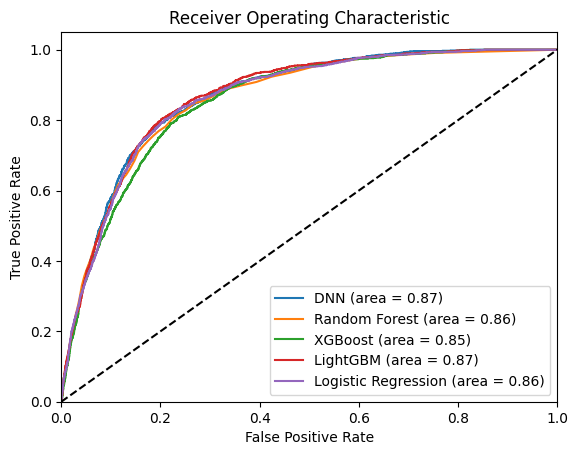

In [52]:
# For DNN
y_pred_dnn = model.predict(X_test_scaled).ravel()
fpr_dnn, tpr_dnn, thresholds_dnn = roc_curve(y_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)

# For Random Forest
y_pred_rf = rf.predict_proba(X_test_scaled)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# For XGBoost
y_pred_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# For LightGBM
y_pred_lgb = lgb_model.predict_proba(X_test_scaled)[:, 1]
fpr_lgb, tpr_lgb, thresholds_lgb = roc_curve(y_test, y_pred_lgb)
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)

# For Logistic Regression
y_pred_logistic = logistic_model.predict_proba(X_test_scaled)[:, 1]
fpr_logistic, tpr_logistic, thresholds_logistic = roc_curve(y_test, y_pred_logistic)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

# Plotting
plt.figure()
plt.plot(fpr_dnn, tpr_dnn, label=f'DNN (area = {roc_auc_dnn:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (area = {roc_auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (area = {roc_auc_xgb:.2f})')
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (area = {roc_auc_lgb:.2f})')
plt.plot(fpr_logistic, tpr_logistic, label=f'Logistic Regression (area = {roc_auc_logistic:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Best Model =

## Risk Over Time

Append predicted risks into each row

Plotting Risk Over Time

In [53]:
# import matplotlib.pyplot as plt

# sorted_data = predictions_dataframe.sort_values(by=['hadm_id', 'timestamp'])
# plt.figure(figsize=(10, 6))
# for hadm_id, group in sorted_data.groupby('hadm_id'):
#     plt.plot(group['timestamp'], group['predicted_risk'], label=hadm_id)

# plt.xlabel('Time')
# plt.ylabel('Predicted Risk')
# plt.title('Risk Over Time')
# plt.legend()  # If you have multiple HADM IDs and want a legend
# plt.show()
